In [1]:
import os, random,re, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from sentence_transformers import SentenceTransformer
from torch_geometric.transforms import RandomLinkSplit
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np



c:\Users\mosca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\mosca\Documents\Maestria\Tercer_trimestre\AA2\TP_AA2\tp_yelp


In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


### Carga de reviews INICIAL - Si no modificamos la data, saltear al siguiente paso

In [4]:
def cargar_reviews(current_dir,nombre_archivo="review_philadelphia.json"):

    """
    Carga un archivo de reseñas JSON y devuelve un df de pandas.
    """
    path = os.path.join(current_dir, "yelp_dataset", nombre_archivo)
    print(f"Leyendo archivo desde: {path}")

        
    reviews = []
    _word_re = re.compile(r"[A-Za-z0-9]+", re.UNICODE)
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):

            # ### Solo para empezar a trabajar la data
            # if i >= 100:   # detener después de 'limit' líneas
            #     break

            line = line.strip()
            if line:  # ignora líneas vacías
                dicc=json.loads(line)
                
                #para evitar tener reviews vacias
                if len(_word_re.findall(dicc['text'])) == 0: 
                    continue

                # nos quedamos con la data que queremos
                for key in ['review_id','funny','cool','useful','date']:
                    del dicc[f'{key}']
                reviews.append(dicc)
    
    print(f"Se cargaron {len(reviews)} reseñas desde {path}")


    rv_df = pd.DataFrame(reviews)
    # Convertir stars a int
    rv_df["stars"] = rv_df["stars"].astype(int)
    # Restar 1 para que queden entre 0 y 4
    rv_df["stars"] = rv_df["stars"] - 1

    return rv_df

In [5]:
# reviews=cargar_reviews(current_dir)
# reviews.head()
# model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
# embeddings = model.encode(reviews['text'], convert_to_tensor=True, show_progress_bar=True)
# embeddings_np = embeddings.cpu().numpy()
# reviews['embedding'] = list(embeddings_np)
# path = os.path.join(current_dir, "yelp_dataset", 'reviews_con_embeddings.pkl')
# print(f"Guardando archivo como: {path}")
# reviews.to_pickle(path)


### Carga de data de Usuarios y locales

In [6]:
business = []
with open(os.path.join(current_dir, "yelp_dataset", "business_philadelphia.json"), "r", encoding="utf-8") as f:
    for line in f:
        business.append(json.loads(line))

df_business = pd.DataFrame(business)

users = []
with open(os.path.join(current_dir, "yelp_dataset", "user_philadelphia.json"), "r", encoding="utf-8") as f:
    for line in f:
        users.append(json.loads(line))

df_users = pd.DataFrame(users)

Creamos vectores binarios de categorias. Contienen un uno solo para las categorias del local

In [7]:
# Paso 1: limpiar la columna
df_business['categories'] = df_business['categories'].fillna('')
df_business['categories_list'] = df_business['categories'].apply(
    lambda x: [c.strip() for c in x.split(',') if c.strip() != '']
)

# Paso 2: ajustar el binarizador
mlb = MultiLabelBinarizer()
mlb.fit(df_business['categories_list'])

# Paso 3: transformar a vectores
category_vectors = mlb.transform(df_business['categories_list'])

# Cada fila de category_vectors es un vector numpy del negocio
df_business['category_vector'] = list(category_vectors)

In [8]:
df_business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,categories_list,category_vector
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Restaurants, Food, Bubble Tea, Coffee & Tea, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...","[Sushi Bars, Restaurants, Japanese]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...","[Korean, Restaurants]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...","[Cocktail Bars, Bars, Italian, Nightlife, Rest...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1...","[Pizza, Restaurants, Salad, Soup]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14564,wPAaAbFbq5wfLfW0gnYU7g,Intermix,1718 Walnut St,Philadelphia,PA,19103,39.950060,-75.170129,2.0,10,0,"{'BusinessParking': '{'garage': False, 'street...","Fashion, Shopping, Women's Clothing","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...","[Fashion, Shopping, Women's Clothing]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14565,JDM7kiCEmeBc_5W-z6eZZw,2601 Parkway Apartments,2601 Pennsylvania Ave,Philadelphia,PA,19130,39.968806,-75.180608,3.0,6,1,{'BusinessAcceptsCreditCards': 'True'},"Real Estate, Apartments, Home Services",None,"[Real Estate, Apartments, Home Services]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14566,9U1Igcpe954LoWZRmNc-zg,Hand & Stone Massage And Facial Spa,"1100 S Columbus Blvd, Ste 24",Philadelphia,PA,19147,39.932756,-75.144504,3.0,32,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Day Spas, Beauty & Spas, Skin Care, Massage","{'Monday': '9:0-22:0', 'Tuesday': '9:0-22:0', ...","[Day Spas, Beauty & Spas, Skin Care, Massage]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14567,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,"1638 Pine St, Fl 1",Philadelphia,PA,19103,39.945966,-75.169666,4.5,39,1,"{'ByAppointmentOnly': 'True', 'GoodForKids': '...","Health & Medical, Yoga, Shopping, Naturopathic...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Health & Medical, Yoga, Shopping, Naturopathi...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,14569.000000,14569.000000,14569.000000,14569.000000,14569.000000
mean,39.976458,-75.152681,3.623035,64.262475,0.723591
std,0.049547,0.053926,0.960691,165.301869,0.447237
min,39.864924,-75.651673,1.000000,5.000000,0.000000
25%,39.948050,-75.175764,3.000000,9.000000,0.000000
50%,39.954384,-75.161018,4.000000,19.000000,1.000000
75%,40.008115,-75.143919,4.500000,53.000000,1.000000
max,40.247267,-74.893799,5.000000,5721.000000,1.000000


In [10]:
df_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.00000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000
mean,38.949202,86.047911,36.994701,52.161941,3.010802,3.663550,3.978382,0.629991,0.446324,0.321867,0.191753,3.22964,6.517514,6.091937,6.091937,2.282289,2.892812
std,143.873461,1166.512581,790.558723,1034.276860,36.159287,1.091632,131.998451,29.665142,33.881293,27.452695,25.237755,146.76918,241.252855,174.518699,174.518699,60.483120,213.486556
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,3.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,5.000000,1.000000,1.000000,0.000000,3.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.000000,21.000000,4.000000,5.000000,1.000000,4.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17473.000000,206296.000000,185823.000000,199878.000000,12497.000000,5.000000,25784.000000,13501.000000,14180.000000,13654.000000,12669.000000,59031.00000,101097.000000,49967.000000,49967.000000,15934.000000,82630.000000


### Preparamos la data para la contruccion del grafo

En esta parte cargamos los datos previamente calculados para las reviews

In [11]:
path = os.path.join(current_dir, "yelp_dataset", 'reviews_con_embeddings.pkl')
reviews_cargados = pd.read_pickle(path)

In [12]:
reviews_cargados.describe()

,stars
count,967506.000000
mean,2.785678
std,1.388202
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


Consideramos como usuarios activos a aquellos con mas de dos reviews, por lo tanto, nos quedaremos solo con sus opiniones para crear el grafo

In [13]:
MIN_REVIEWS = 2

user_counts = reviews_cargados['user_id'].value_counts()
valid_users = user_counts[user_counts >= MIN_REVIEWS].index

df_filtrado = reviews_cargados[reviews_cargados['user_id'].isin(valid_users)].reset_index(drop=True)
unique_reviews = reviews_cargados[~reviews_cargados['user_id'].isin(valid_users)].reset_index(drop=True)

reviews_cargados=df_filtrado

In [14]:
reviews_cargados.describe()

,stars
count,801541.000000
mean,2.829345
std,1.314086
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


creo q esto puedo borrarlo

In [15]:
# valid_business = reviews_cargados['business_id'].unique()
# valid_users     = reviews_cargados['user_id'].unique()

# df_users_filtrado = df_users[df_users['user_id'].isin(valid_users)].reset_index(drop=True)
# df_business_filtrado = df_business[df_business['business_id'].isin(valid_business)].reset_index(drop=True)

# df_users=df_users_filtrado
# df_business=df_business_filtrado

fin de parte que se puede borrar

In [16]:
#cargamso los embeddings de reseñas
embeddings_car_np = np.stack(reviews_cargados['embedding'].values)
edge_embeddings = torch.from_numpy(embeddings_car_np)

In [17]:
# Mapeo de ID unico a indice (0, 1, 2, ...)
user_mapping = {id: i for i, id in enumerate(reviews_cargados['user_id'].unique())}
place_mapping = {id: i for i, id in enumerate(reviews_cargados['business_id'].unique())}

# Aplicamos el mapeo al df para obtener los indices de las aristas
user_indices_mapped = reviews_cargados['user_id'].map(user_mapping)
place_indices_mapped = reviews_cargados['business_id'].map(place_mapping)


# Preparamos grafo
NUM_NODES_USER = len(user_mapping) 
NUM_NODES_PLACE = len(place_mapping)
NUM_RATINGS = reviews_cargados.shape[0]

data = HeteroData()
data['user'].num_nodes = NUM_NODES_USER
data['place'].num_nodes = NUM_NODES_PLACE

# Datos para las aristas
ratings = reviews_cargados['stars']

# Convertimos series de pandas a tensores de PyTorch antes de apilarlas

data['user', 'rates', 'place'].edge_index = torch.stack([
    torch.from_numpy(user_indices_mapped.values).long(),
    torch.from_numpy(place_indices_mapped.values).long()
], dim=0)

# Agragamos label de buena arista
data['user', 'rates', 'place'].edge_attr_label  = torch.from_numpy((ratings > 3).values).long()

# Cargamos embedding de reseña a la arista
data['user', 'rates', 'place'].edge_attr = edge_embeddings

In [18]:
inv_user = [None] * NUM_NODES_USER
for uid, idx in user_mapping.items():
    inv_user[idx] = uid

data['user'].id = inv_user

inv_place = [None] * NUM_NODES_PLACE
for bid, idx in place_mapping.items():
    inv_place[idx] = bid

data['place'].id = inv_place

In [19]:
df_business

# Filtrar df_business para quedarnos solo con los negocios presentes en place_mapping
df_business_filtrado = df_business[df_business['business_id'].isin(place_mapping.keys())]

# Reordenar según el índice (orden) asignado en place_mapping
df_business_filtrado = df_business_filtrado.set_index('business_id')
df_business_ordenado = df_business_filtrado.loc[place_mapping.keys()]  # Ordena exacto

# Convertir a matriz final
business_vec_np = np.stack(df_business_ordenado['category_vector'].values)
business_Vec = torch.from_numpy(business_vec_np).float()

# Asignar al grafo
data['place'].x = business_Vec

In [20]:
print(f"Forma del edge_attr: {data['user', 'rates', 'place'].edge_attr_label.shape}")
print(f"Forma del atributos de business: {data['place'].x.shape}")

Forma del edge_attr: torch.Size([801541])
Forma del atributos de business: torch.Size([14534, 1027])


In [21]:
data

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 801541],
    edge_attr_label=[801541],
    edge_attr=[801541, 384],
  }
)

### Dividimos la data

In [22]:
transform = RandomLinkSplit(
    num_val=0.1, num_test=0.1, is_undirected=False,
    edge_types=[('user', 'rates', 'place')],
    add_negative_train_samples= False
)
train_data_raw, val_data_raw, test_data_raw = transform(data)

In [23]:
train_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  }
)

In [24]:
val_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[160308],
    edge_label_index=[2, 160308],
  }
)

Creamso una funcion para crear los vectores de usuarios en base a los lugares que visitaron

In [25]:
def compute_user_vectors(data):
    edge_index = data['user', 'rates', 'place'].edge_index
    place_vecs = data['place'].x  # [num_places, dim]
    
    num_users = data['user'].num_nodes
    dim = place_vecs.size(1)

    # Inicializamos un acumulador y un contador
    user_sum = torch.zeros((num_users, dim))
    user_count = torch.zeros(num_users)

    # Descomponemos aristas
    user_idx = edge_index[0]
    place_idx = edge_index[1]

    # Sumamos vectores de lugares visitados
    user_sum.index_add_(0, user_idx, place_vecs[place_idx])
    user_count.index_add_(0, user_idx, torch.ones_like(user_idx, dtype=torch.float))

    # Promediamos, evitando divisiones por cero
    user_mean = user_sum / user_count.clamp(min=1).unsqueeze(1)

    return user_mean

In [26]:
train_user_vec = compute_user_vectors(train_data_raw)
val_user_vec   = compute_user_vectors(val_data_raw)
test_user_vec  = compute_user_vectors(test_data_raw)

In [27]:
train_data_raw['user'].x = train_user_vec
val_data_raw['user'].x   = val_user_vec
test_data_raw['user'].x  = test_user_vec

train_data_raw = T.ToUndirected()(train_data_raw)
val_data_raw = T.ToUndirected()(val_data_raw)
test_data_raw = T.ToUndirected()(test_data_raw)

In [28]:

train_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1027],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

In [29]:

val_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1027],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[160308],
    edge_label_index=[2, 160308],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
  }
)

Concatenamos el promedio de los vectores semanticos de las reseñas de cada usuario y lugar al fiinal de los atributos de cada uno 

In [30]:
def scatter_mean_torch(src, index, dim_size):


    out = torch.zeros(dim_size, src.size(1), device=src.device)
    out = out.index_add(0, index, src)

    # contadores por nodo
    count = torch.zeros(dim_size, device=src.device).index_add(0, index, torch.ones(src.size(0), device=src.device))

    # evitar división por cero
    count = count.clamp(min=1).unsqueeze(1)

    return out / count


def vec_aristas(data_input):
    data = data_input

    # Edges user → place
    src = data["user", "rates", "place"].edge_index[0]  
    edge_attr = data["user", "rates", "place"].edge_attr 
    user_review_mean = scatter_mean_torch(edge_attr, src, dim_size=data['user'].num_nodes)

    # Edges place → user
    src_p = data["place", "rev_rates", "user"].edge_index[0]  # places
    edge_attr_p = data["place", "rev_rates", "user"].edge_attr  # [774006, 384]
    place_review_mean = scatter_mean_torch(edge_attr_p, src_p, dim_size=data['place'].num_nodes)

    # Concatenar a las features de usuario
    data['user'].x = torch.cat([data['user'].x, user_review_mean], dim=1)
    data['place'].x = torch.cat([data['place'].x, place_review_mean], dim=1)

    return data


In [31]:
train_data_raw=vec_aristas(train_data_raw)
val_data_raw=vec_aristas(val_data_raw)
test_data_raw=vec_aristas(test_data_raw)

In [32]:

train_data_raw


HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1411],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1411],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

Recuperamos los Usuarios con una sola review y los consideraremos 'cold start'

In [33]:
#Obtenemos la cantidad de nodos a agg
users_unique_review=unique_reviews['user_id'].unique()
N=len(users_unique_review)

#Obtenemos sus atributos

#Filtrar los business que aparecen en unique_reviews
business_ids_unique = unique_reviews['business_id'].unique()

df_business_unique = df_business[df_business['business_id'].isin(business_ids_unique)]

# Asegurarnos de que estén alineados por business_id
df_merged = df_business_unique.merge(
    unique_reviews[['business_id', 'embedding']],
    on='business_id',
    how='inner'
)

# Convertimos todo a numpy arrays
category_vecs = np.stack(df_merged['category_vector'].values)
review_embeddings = np.stack(df_merged['embedding'].values)

# Concatenamos por fila 
user_final_features_np = np.concatenate([category_vecs, review_embeddings], axis=1)

# Pasamos a tensores
user_final_features = torch.from_numpy(user_final_features_np).float()

# Convertir los user_id nuevos a lista
new_user_ids = list(users_unique_review)



In [34]:
train_data_raw['user'].num_nodes is val_data_raw['user'].num_nodes

True

No es necesario agg a todos porque son lo mismo (se puede probar con train_data_raw['user'].id.extend(new_user_ids) is val_data_raw['user'].id.extend(new_user_ids) )

In [35]:
train_data_raw['user'].x = torch.cat([train_data_raw['user'].x, user_final_features], dim=0)
train_data_raw['user'].num_nodes += N
train_data_raw['user'].id.extend(new_user_ids)

In [36]:
val_data_raw['user'].x = torch.cat([val_data_raw['user'].x, user_final_features], dim=0)
val_data_raw['user'].num_nodes += N

In [37]:
test_data_raw['user'].x = torch.cat([test_data_raw['user'].x, user_final_features], dim=0)
test_data_raw['user'].num_nodes += N

In [38]:
train_data_raw

HeteroData(
  user={
    num_nodes=279837,
    id=[279837],
    x=[279837, 1411],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1411],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

Creamos nuestro modelo. Usamos capas de HGTConv para crear los  vectores de nuestros users/places y despues los metemos a un clasificador 

In [39]:
import torch
import torch.nn as nn
from torch_geometric.nn import HGTConv
from torch_geometric.nn import Linear

class HGTBinaryModel(nn.Module):
    def __init__(self, metadata, hidden_channels=128, heads=2):
        super().__init__()

        # Proyecciones iniciales para cada tipo de nodo
        self.node_emb = nn.ModuleDict()
        for node_type in metadata[0]:
            self.node_emb[node_type] = Linear(-1, hidden_channels)

        # Dos capas heterogéneas
        self.conv1 = HGTConv(
            in_channels={nt: hidden_channels for nt in metadata[0]},
            out_channels=hidden_channels,
            metadata=metadata,
            heads=heads
        )


        self.conv2 = HGTConv(
            in_channels={nt: hidden_channels for nt in metadata[0]},
            out_channels=hidden_channels,
            metadata=metadata,
            heads=heads
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(4 * hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.out_layer = nn.Linear(hidden_channels + 4 * hidden_channels, 1)

    def encode_nodes(self, data):
        x_dict = {}
        
        for nt, x in data.x_dict.items():
            x_dict[nt] = self.node_emb[nt](x)

        h = self.conv1(x_dict, data.edge_index_dict)
        for nt in h:
            h[nt] = h[nt] + x_dict[nt]

        x_dict = h
        h = self.conv2(x_dict, data.edge_index_dict)
        for nt in h:
            h[nt] = h[nt] + x_dict[nt]

        return h
    
    def predict_edges(self, h, edge_label_index):

        user_idx, place_idx = edge_label_index
        u = h["user"][user_idx]
        p = h["place"][place_idx]

        edge_repr = torch.cat([u, p, u*p, torch.abs(u-p)], dim=1)
        h2 = self.classifier(edge_repr)
        h2 = torch.cat([h2, edge_repr], dim=1)
        logit = self.out_layer(h2).squeeze()
        return logit

    def forward(self, data):
        x_dict = {}

        # Inicial
        for nt, x in data.x_dict.items():
            x_dict[nt] = self.node_emb[nt](x)

        h = self.conv1(x_dict, data.edge_index_dict)
        for nt in h:
            h[nt] = h[nt] + x_dict[nt]   # residual simple
        x_dict = h

        h = self.conv2(x_dict, data.edge_index_dict)

        for nt in h:
            h[nt] = h[nt] + x_dict[nt]   # residual simple
        x_dict = h

        user_idx, place_idx = data['user', 'rates', 'place'].edge_label_index

        u = x_dict["user"][user_idx]
        p = x_dict["place"][place_idx]

        edge_repr = torch.cat([
            u,
            p,
            u * p,
            torch.abs(u - p)
        ], dim=1)

        h = self.classifier(edge_repr)
        h = torch.cat([h, edge_repr], dim=1)  # Residual 
        logit = self.out_layer(h).squeeze()

        return logit

In [40]:

train_data_raw = train_data_raw.to(device)
val_data_raw   = val_data_raw.to(device)
test_data_raw = test_data_raw.to(device)

In [41]:


# y_train = train_data_raw["user","rates","place"].edge_attr_label[train_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
# y_val   = val_data_raw["user","rates","place"].edge_attr_label[val_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
# y_test = test_data_raw["user","rates","place"].edge_attr_label[test_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)

# val_edge_index = val_data_raw["user", "rates", "place"].edge_label_index
# train_edge_index = train_data_raw["user", "rates", "place"].edge_label_index
# test_edge_index = test_data_raw["user", "rates", "place"].edge_label_index



In [42]:

# import gc

# del model
# del y_train
# del y_val
# del y_test

# gc.collect()
# torch.cuda.empty_cache()

# torch.cuda.synchronize()
# gc.collect()
# torch.cuda.empty_cache()

In [43]:
model = HGTBinaryModel(
    
    metadata=train_data_raw.metadata(),
    hidden_channels=128,
    heads=2
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


y_train = train_data_raw["user","rates","place"].edge_attr_label[train_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
y_val   = val_data_raw["user","rates","place"].edge_attr_label[val_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
y_test = test_data_raw["user","rates","place"].edge_attr_label[test_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)

# un desbalanceo en la clases nos estaba afectando el entraenamiento
pos_weight = torch.tensor([(1 - float(y_train.mean())) / float(y_train.mean())]).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight,reduction = 'none')

In [44]:
epochs = 80
performance_acc=[]
performance_recall_neg = []

# Para correccion del popularity bias
place_degrees = torch.bincount(train_data_raw['user','rates','place'].edge_index[1], minlength=NUM_NODES_PLACE)
edge_place_indices = train_data_raw['user','rates','place'].edge_index[1]
weights_pop = 1.0 / torch.sqrt(place_degrees[edge_place_indices] + 1e-6)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    h_train = model.encode_nodes(train_data_raw) 
    logits_train = model.predict_edges(h_train, train_data_raw['user','rates','place'].edge_label_index)

    loss_raw  = loss_fn(logits_train, y_train)

    loss= (loss_raw * weights_pop).mean()

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        prob = torch.sigmoid(logits_train)
        pred = (prob > 0.5).long()
        correct = (pred == y_train.long()).sum().item()
        acc = correct / y_train.size(0)

        true_neg = ((pred == 0) & (y_train == 0)).sum().item()
        false_pos = ((pred == 1) & (y_train == 0)).sum().item()
        recall_neg = true_neg / (true_neg + false_pos + 1e-12)

    model.eval()
    with torch.no_grad():
        #Validation
        logits_val = model.predict_edges(h_train, val_data_raw['user','rates','place'].edge_label_index)
        val_prob = torch.sigmoid(logits_val)
        val_pred = (val_prob > 0.5).long()
        val_acc = (val_pred == y_val.long()).sum().item() / y_val.size(0)

        val_true_neg = ((val_pred == 0) & (y_val == 0)).sum().item()
        val_false_pos = ((val_pred == 1) & (y_val == 0)).sum().item()
        val_recall_neg = val_true_neg / (val_true_neg + val_false_pos + 1e-12)

        #testing
        logits_test = model.predict_edges(h_train, test_data_raw['user','rates','place'].edge_label_index)
        test_prob = torch.sigmoid(logits_test)
        test_pred = (test_prob > 0.5).long()
        test_acc = (test_pred == y_test.long()).sum().item() / y_test.size(0)

        test_true_neg = ((test_pred == 0) & (y_test == 0)).sum().item()
        test_false_pos = ((test_pred == 1) & (y_test == 0)).sum().item()
        test_recall_neg = test_true_neg / (test_true_neg + test_false_pos + 1e-12)

    a=[epoch,acc,val_acc,test_acc]
    r = [epoch, recall_neg, val_recall_neg, test_recall_neg]
    print(a,r)
    performance_acc.append(a)
    performance_recall_neg.append(r)

[0, 0.4819059530623034, 0.43291039748484167, 0.43276692367193154] [0, 0.41260077603502215, 0.06642066420664207, 0.06735181746387484]
[1, 0.5612686808071325, 0.47275868952266886, 0.4729645432542356] [1, 0.5122969260331695, 0.24361730573827478, 0.24528825425284412]
[2, 0.5956243674296239, 0.5300172168575492, 0.5290004241834468] [2, 0.5576759180346093, 0.5093320498422376, 0.5086764423384773]
[3, 0.6199961636409854, 0.5442460763031165, 0.5438967487586396] [3, 0.5943443668644691, 0.5432162147708434, 0.5427312117137307]
[4, 0.6313446126447017, 0.5481947251540784, 0.5478142076502732] [4, 0.5818092308995336, 0.5113963313546179, 0.5120915241937205]
[5, 0.6471890872740486, 0.5832148114878858, 0.5821793048381865] [5, 0.6024540916525947, 0.6520883469704263, 0.6503916672002732]
[6, 0.6633485800013411, 0.6095141851935025, 0.6111423010704394] [6, 0.6356949642420424, 0.81976576287502, 0.820153251798254]
[7, 0.6762892739456641, 0.6145045786860294, 0.6162013124734885] [7, 0.6574329439042078, 0.896486443

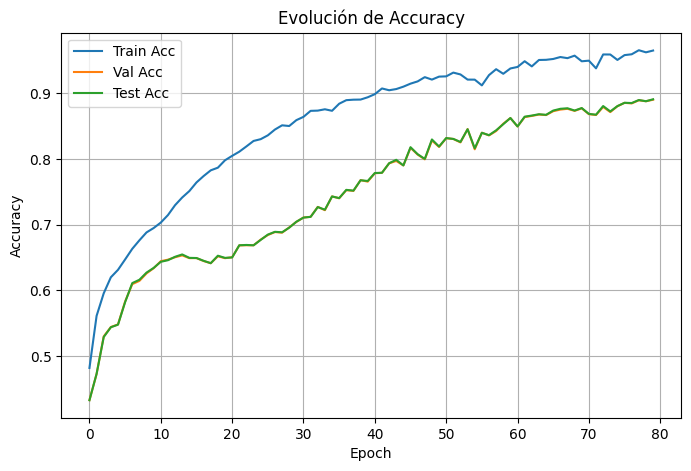

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir a array para indexar más fácil
perf = np.array(performance_acc)

epochs   = perf[:, 0]
train_acc = perf[:, 1]
val_acc   = perf[:, 2]
test_acc  = perf[:, 3]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy")
plt.legend()
plt.grid(True)

plt.show()

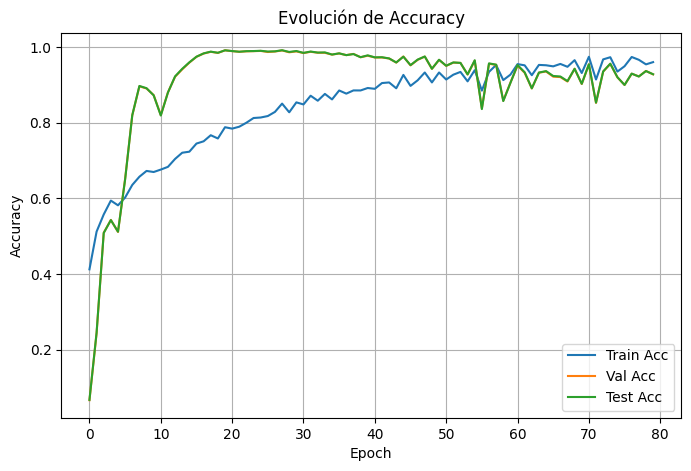

In [46]:
# Convertir a array para indexar más fácil
perf = np.array(performance_recall_neg)

epochs   = perf[:, 0]
train_acc = perf[:, 1]
val_acc   = perf[:, 2]
test_acc  = perf[:, 3]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
métricas (AUC, Recall@K)

In [ ]:
from pyvis.network import Network

def plot_interactive_graph(data, num_edges=10000):
    edge_index = data['user', 'rates', 'place'].edge_index
    idx = torch.randint(0, edge_index.size(1), (num_edges,))
    edges_sample = edge_index[:, idx]

    net = Network(
    notebook=True,
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black",
    cdn_resources='in_line'  # evita el warning
    )

    for u, p in edges_sample.t().tolist():
        net.add_node(f"user_{u}", color="#1f77b4", title=f"User {u}")
        net.add_node(f"place_{p}", color="#ff7f0e", title=f"Place {p}")
        net.add_edge(f"user_{u}", f"place_{p}")


    import webbrowser
    webbrowser.open("graph.html")

# Ejemplo
plot_interactive_graph(train_data_raw, num_edges=100000)

KeyboardInterrupt: 

### Guardar modelo

In [47]:
path_model=os.path.join(current_dir, "modelo_yelp_philly.pth")
torch.save(model.state_dict(), path_model)

### Cargar modelo y evaluar resultados

In [48]:
model1 = model = HGTBinaryModel(
    metadata=train_data_raw.metadata(),
    hidden_channels=128,
    heads=2
) 
model1.load_state_dict(torch.load("modelo_yelp_philly.pth"))
model1.eval()
model1=model1.to(device)


In [82]:
# 1) Identificar el nuevo usuario
# new_user_id = NUM_NODES_USER+59
new_user_id=35
print(new_user_id)
num_places = train_data_raw['place'].num_nodes

# 2) Crear edge_label_index user_new → all places
user_nodes = torch.full((num_places,), new_user_id, dtype=torch.long)
place_nodes = torch.arange(num_places, dtype=torch.long)
edge_label_index_new = torch.stack([user_nodes, place_nodes], dim=0)

# 3) Encodear nodos
h = model1.encode_nodes(train_data_raw)

# 4) Predecir para TODOS los lugares
scores = model1.predict_edges(
    h,
    edge_label_index_new
)
prob = torch.sigmoid(scores)


#Otra parte apra combatir popularity bias
place_degrees = torch.bincount(train_data_raw['user','rates','place'].edge_index[1], minlength=NUM_NODES_PLACE)
alpha = 0.3
pop = place_degrees / place_degrees.max()
adjusted_prob = prob - alpha * pop



# 5) Top-K recomendaciones
K = 15
topk = torch.topk(adjusted_prob, K)
recommended_place_ids = topk.indices.tolist()
recommended_probs = topk.values.tolist()

print("=== Top K recomendaciones ===")
for rank, (pid, p) in enumerate(zip(recommended_place_ids, recommended_probs), start=1):
    print(f"{rank}. place_index={pid}  prob={p:.4f}")

35
=== Top K recomendaciones ===
1. place_index=8429  prob=1.0000
2. place_index=4048  prob=0.9999
3. place_index=8467  prob=0.9999
4. place_index=8538  prob=0.9999
5. place_index=1484  prob=0.9998
6. place_index=8654  prob=0.9998
7. place_index=2506  prob=0.9998
8. place_index=5022  prob=0.9998
9. place_index=8229  prob=0.9997
10. place_index=704  prob=0.9997
11. place_index=9453  prob=0.9997
12. place_index=10156  prob=0.9997
13. place_index=1002  prob=0.9997
14. place_index=4311  prob=0.9997
15. place_index=10106  prob=0.9997


Ver lugares recomendados:

In [83]:
business_ids_from_graph = [train_data_raw['place'].id[i] for i in recommended_place_ids]
business_ids_from_graph

['9iF5ALxAskaBFRzqoG7SNQ',
 'X9rHylXdk7KEb-r4ByDmxw',
 'crvCdEjWgsSQSsX-VKs9ew',
 '3-rScHRALlmQnsbMz_XFTA',
 'fN1xl3d8EdFRpyE1NVI2nw',
 'wJDWYnlaRgYNeas08Tz0cQ',
 'QxecXQwEvcFfwYpsuNvaGA',
 'e_GHaJxhgEz-OMn_PEV_Ow',
 '5l8v9CNdQOZtD2wKMqAGAA',
 'wLqMLEOEtDSpYl9so6Yf8g',
 'mFOCLmmLVeVB07v8g0B98Q',
 'Vn2nFA9JaEXTebCExP869w',
 'NSDifyQNkKyPUV_f23ldaQ',
 'FfrMJk5L3weVgVGhpG4c2Q',
 'PSZauAAMc5lWDL0zC7-0rw']

In [84]:
df_recommended = (
    df_business[df_business['business_id'].isin(business_ids_from_graph)]
        .drop_duplicates(subset='business_id')
)

df_recommended[['name','address','city','latitude','longitude','categories']]

,name,address,city,latitude,longitude,categories
107,Feet First Team Building,,Philadelphia,39.935064,-75.151619,"Scavenger Hunts, Active Life, Team Building Ac..."
840,The Stock Group,542 Carpenter Ln,Philadelphia,40.046606,-75.195443,"Painters, Contractors, Home Services"
1029,Sabel's Gaslight Pub,3979 Ford Rd,Philadelphia,39.999872,-75.209147,"Bars, Pubs, Adult Entertainment, Nightlife"
2772,Than's Auto Body Shop,7011 Grays Ave,Philadelphia,39.918206,-75.239748,"Insurance, Body Shops, Financial Services, Car..."
3468,Little Geniuses Academy,8012 Bustleton Ave,Philadelphia,40.060183,-75.052160,"Child Care & Day Care, Local Services"
3782,Rustika Pollo a La Brasa,3945 Chestnut St,Philadelphia,39.955881,-75.202003,"Restaurants, Chicken Shop, Peruvian"
5494,Sweetwater Portraits,755 S 3rd St,Philadelphia,39.939146,-75.148084,"Boudoir Photography, Event Planning & Services..."
7380,A-1 Appliance Repairs,,Philadelphia,40.035838,-75.174734,"Home Services, Handyman, Plumbing, Appliances ..."
7645,Giggles Gifts,7400 Frankford Ave,Philadelphia,40.038074,-75.037956,"Flowers & Gifts, Gift Shops, Jewelry, Shopping"
7913,Bottoms Up 215,2515 Island Ave,Philadelphia,39.912440,-75.242740,"Nightlife, Arts & Entertainment, Social Clubs,..."


In [85]:
new_user_id_from_graph = train_data_raw['user'].id[new_user_id]
reviewed_business_id=reviews_cargados[ reviews_cargados['user_id'] == new_user_id_from_graph]['business_id']

df_reviewed = (
    df_business[df_business['business_id'].isin(reviewed_business_id)]
        .drop_duplicates(subset='business_id')
)
df_reviewed


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,categories_list,category_vector
366,qHCfhWPyb1GXpzq9Wk3Vkg,New England Pizza,6728 Bustleton Ave,Philadelphia,PA,19149,40.040037,-75.066294,3.0,22,1,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Pizza, Restaurants","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","[Pizza, Restaurants]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
973,eaDZlSuVS0EY67Ke6pRP6Q,Penang,117 N 10th St,Philadelphia,PA,19107,39.954044,-75.155980,3.5,1112,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Malaysian, Asian Fusion, Cambodian, Chinese, R...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...","[Malaysian, Asian Fusion, Cambodian, Chinese, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1490,cYU-9JM4x4ra-aCxbgtxfg,Mayfair Pizza,7424 Frankford Ave,Philadelphia,PA,19136,40.038440,-75.036860,3.5,11,1,"{'RestaurantsAttire': 'u'casual'', 'Alcohol': ...","Restaurants, Pizza","{'Monday': '14:0-22:0', 'Tuesday': '14:0-22:0'...","[Restaurants, Pizza]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4501,e3ph3NO-eTeWnJozPRxxkQ,Top Cut Salon,237 N 10th St,Philadelphia,PA,19107,39.956475,-75.155427,3.5,13,1,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Hair Salons, Beauty & Spas","{'Monday': '19:0-19:30', 'Tuesday': '9:0-19:45...","[Hair Salons, Beauty & Spas]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6138,r9RdpSEb2-0SGD_UcvnDkA,Four Seasons Diner,2811 Cottman Ave,Philadelphia,PA,19149,40.044186,-75.052947,3.5,195,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Res...","Diners, Restaurants","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...","[Diners, Restaurants]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
